## Google Authentications & Libraries



In [ ]:
# Code to read csv file into Colaboratory:
# reference: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Data

In [ ]:
# Cities Questionnaire
cities_q_id = '1MdA6rqOjPAugJR4qFOgoNGBiLtpqcLmV'
cities_q_file = my_drive.CreateFile({'id':cities_q_id}) 
cities_q_file.GetContentFile('cities_q.csv')
cities_q_df = pd.read_csv('cities_q.csv', encoding='latin1')
print(cities_q_df.shape)
cities_q_df.head()

(135511, 12)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Project Year,Account Number,Account Name,Question Number,Question Name,Row Number,Row Name,Column Number,Column Name,Response Answer,Comments,File Name
0,2017,63999,"City of Miami Beach, FL",0.1,Please give a general description and introdu...,1,NaN,C1,Administrative boundary,City/Municipality,NaN,NaN
1,2017,62864,"City of Lancaster, PA",0.1,Please give a general description and introdu...,1,NaN,C1,Administrative boundary,City/Municipality,NaN,NaN
2,2017,61790,"City of Emeryville, CA",0.1,Please give a general description and introdu...,1,NaN,C1,Administrative boundary,City/Municipality,NaN,NaN
3,2017,58485,Abington Township,0.1,Please give a general description and introdu...,1,NaN,C1,Administrative boundary,City/Municipality,NaN,NaN
4,2017,54102,City of Albany,0.1,Please give a general description and introdu...,1,NaN,C1,Administrative boundary,City/Municipality,NaN,NaN


In [ ]:
# Corporations Questionnaire
corp_q_id = '11Ax7FfLRBKqAyGc_ctieDp5BjlI5pPqa'
corp_q_file = my_drive.CreateFile({'id':corp_q_id}) 
corp_q_file.GetContentFile('corp_q.csv')
corp_q_df = pd.read_csv('corp_q.csv', encoding='latin1')
print(corp_q_df.shape)
corp_q_df.head()

(747904, 10)


,Project Year,Account Number,Account Name,Question Number,Question Name,Row Number,Row Name,Column Number,Column Name,Response Answer
0,2018,285,3M Company,CC0.1,Give a general description and introduction to...,0.0,NaN,C0,NaN,3M is a global science company committed to in...
1,2018,64,Abbott Laboratories,CC0.1,Give a general description and introduction to...,0.0,NaN,C0,NaN,Abbott is a global healthcare company that hel...
2,2018,45103,AbbVie Inc,CC0.1,Give a general description and introduction to...,0.0,NaN,C0,NaN,"AbbVie is a global, research-driven biopharmac..."
3,2018,291,Abercrombie & Fitch Co.,CC0.1,Give a general description and introduction to...,0.0,NaN,C0,NaN,"Abercrombie & Fitch Co. (''A&F ), a company i..."
4,2018,58,ABM INDUSTRIES INC,CC0.1,Give a general description and introduction to...,0.0,NaN,C0,NaN,Building Value With Integrated Facilities Solu...


In [ ]:
# Data Catalog (contains metadata & links from all datasets)
data_catalog_id = '1llkhxscCNYR1CE9LgRPBngVwuC2SP0ab'
data_catalog_file = my_drive.CreateFile({'id':data_catalog_id}) 
data_catalog_file.GetContentFile('data_catalog.csv')
data_catalog_df = pd.read_csv('data_catalog.csv', encoding='latin1')
print(data_catalog_df.shape)
data_catalog_df.head()

(314, 14)


,ï»¿CDP Dataset Source File Name,Project Name,Datapoint Theme,2019 Question Number,2019 Question Name,Use,2019 Row Number,2019 Row Name,2019 Column Number,2019 Column Name,Comparable 2018 datapoint provided,Comparable 2017 datapoint provided,Comparable 2016 datapoint provided,Comparable 2015 datapoint provided
0,Cities_Data_2017-2019_mb2.cv,Cities,City details,0.1,Please give a general description and introduc...,0,1.0,City boundary,1,Administrative boundary,0.1,0.1,NaN,NaN
1,Cities_Data_2017-2019_mb2.cv,Cities,City details,0.1,Please give a general description and introduc...,1,1.0,City boundary,2,Description of city,0.1,0.1,NaN,NaN
2,Cities_Data_2017-2019_mb2.cv,Cities,City details,0.2,If you have not previously submitted your Lett...,0,0.0,NaN,NaN,NaN,0.2,0.2,NaN,NaN
3,Cities_Data_2017-2019_mb2.cv,Cities,City details,0.3,Please provide information about your cityâs...,0,1.0,Please complete,1,Leader title,0.3,0.3,NaN,NaN
4,Cities_Data_2017-2019_mb2.cv,Cities,City details,0.3,Please provide information about your cityâs...,0,1.0,Please complete,2,Leader name,0.3,0.3,NaN,NaN


## Clean Data

Filters:


*   2019 Questions
*   Recommended Challenge 1 Questions w/ Themes City/Company details & Climate-related targets and goals
*   Free text questions (manually identified)






In [ ]:

catalog_cols = ['Project Name', 'Datapoint Theme', '2019 Question Number', '2019 Question Name', '2019 Row Number', '2019 Row Name', '2019 Column Number', '2019 Column Name']
data_catalog_rec_df = data_catalog_df.loc[(data_catalog_df['Use'] == 1) & 
                                          (data_catalog_df['Datapoint Theme'].isin(['City details', 'Climate-related targets and goals', 'Company details', 'Climate targets and goals'])), 
                                          catalog_cols]

cities_q_rec_2019_df = cities_q_df[cities_q_df['Project Year'] == 2019].merge(data_catalog_rec_df, 
                                         left_on = ['Question Number', 'Column Number'],
                                         right_on = ['2019 Question Number', '2019 Column Number'])
cities_q_rec_2019_df['Account Type'] = "City"

corp_q_rec_2019_df = corp_q_df[corp_q_df['Project Year'] == 2019].merge(data_catalog_rec_df, 
                                     left_on = ['Question Number', 'Column Number'],
                                     right_on = ['2019 Question Number', '2019 Column Number'])
corp_q_rec_2019_df['Account Type'] = "Corporation"


#cities_q_rec_2019_df.head()
print("\nNumber of Relevant Responses: " + str(cities_q_rec_2019_df.shape[0] + corp_q_rec_2019_df.shape[0]))
print("\nRelevant City Questions: " + "\n\t- " + "\n\t- ".join(cities_q_rec_2019_df['Question Name'].unique()))
print("\nRelevant Corp Questions: " + "\n\t- " + "\n\t- ".join(corp_q_rec_2019_df['Question Name'].unique()))

#distinct_entries = cities_q_rec_2019_df[['Question Number','Question Name', 'Row Number', 'Row Name', 'Column Number', 'Column Name']].drop_duplicates()
#print("\nNumber of Distinct Questions: ", distinct_entries.shape[0])
#distinct_entries.head(31)

data_cols = ['Account Type', 'Account Number', 'Account Name', 'Question Number', 
             'Question Name', 'Row Number', 'Row Name', 'Column Number', 
             'Column Name', 'Response Answer']

# union dataframes
q_rec_2019_df = pd.concat([cities_q_rec_2019_df[data_cols],corp_q_rec_2019_df[data_cols]])

num_cities_with_text_responses = q_rec_2019_df.loc[q_rec_2019_df['Account Type'] == "City", 'Account Number'].drop_duplicates().shape[0]
num_corps_with_text_responses = q_rec_2019_df.loc[q_rec_2019_df['Account Type'] == "Corporation", 'Account Number'].drop_duplicates().shape[0]

print("\nNumber of Cities w/ Text Responses: " + str(num_cities_with_text_responses))
print("\nNumber of Corporations w/ Text Responses: " + str(num_corps_with_text_responses))

print("\nCombined Data Frame:")
q_rec_2019_df.head()


Number of Relevant Responses: 19433

Relevant City Questions: 
	- Please give a general description and introduction to your city including your citys reporting boundary in the table below.
	- Please provide details of your total city-wide base year intensity target. An intensity target is usually measured per capita or per unit GDP. If you have an absolute emissions reduction target, please select Base year emissions (absolute) target in question 5.0.
	- Please provide details of your total city-wide base year emissions reduction (absolute) target. In addition, you may add rows to provide details of your sector-specific targets, by providing the base year emissions specific to that target.
	- Please provide details of your total fixed level target.
	- Please provide details of your total city-wide baseline scenario target, including projected business as usual emissions.

Relevant Corp Questions: 
	- Give a general description and introduction to your organization.
	- Why did you 

,Account Type,Account Number,Account Name,Question Number,Question Name,Row Number,Row Name,Column Number,Column Name,Response Answer
0,City,58485,Abington Township,0.1,Please give a general description and introduc...,1.0,City boundary,2,Description of city,Abington Township is the 52nd certified STAR C...
1,City,55799,"Arlington, VA",0.1,Please give a general description and introduc...,1.0,City boundary,2,Description of city,"Arlington Va., is a world-class residential, b..."
2,City,74414,Boulder County,0.1,Please give a general description and introduc...,1.0,City boundary,2,Description of city,"Located in north-central Colorado, northwest o..."
3,City,63941,"Broward County, FL",0.1,Please give a general description and introduc...,1.0,City boundary,2,Description of city,"Broward County, Florida"
4,City,49339,City and County of Honolulu,0.1,Please give a general description and introduc...,1.0,City boundary,2,Description of city,"Established by city charter in 1907, the City ..."


Concatenate all relevant text responses by Account to get one long text response.





In [ ]:
q_rec_2019_df['Response Answer'] = q_rec_2019_df['Response Answer'].astype('str')
#q_rec_2019_df['Response Answer'] = q_rec_2019_df['Response Answer'].str.lower()

groupby_cols = ['Account Type', 'Account Number', 'Account Name']
df2 = q_rec_2019_df.sort_values(by='Row Number').groupby(groupby_cols)['Response Answer'].apply('. '.join).reset_index()

df2.head()

,Account Type,Account Number,Account Name,Response Answer
0,City,1093,City of Atlanta,Benchmarking and retrofits for buildings large...
1,City,1184,City of Austin,Our target is net-zero emissions by 2050 and i...
2,City,35268,City of Boston,Public facility. Commercial buildings. Residen...
3,City,35853,City of Baltimore,Key findings by sector provide guidance for wh...
4,City,37241,City of Berkeley,Public facility. Industrial facilities. Reside...


Use NLTK library to extract tokens from cleaned text

In [ ]:
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('punkt')

def initial_clean(text):
    """
    Cleans text using string replace & tokenizes:
    - removes websites, emails & any punctuation
    - converts to lower case
    - removes N/A responses
    """
    text = text.lower() # lower case the text
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = re.sub("nan", "", text)
    text = re.sub("question not applicable", "", text)
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Removes all stopwords from tokens
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Converts tokens to stem words, so plural and singular tokens are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # exclude 1 letter words
    except IndexError: 
        pass
    return text

def apply_all(text):
    """
    Applies all cleaning steps to text response
    """
    return stem_words(remove_stop_words(initial_clean(text)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
t1 = time.time()
df2['Tokenized Response Answer'] = df2['Response Answer'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df2), "accounts:", round((t2-t1)/60, 3), "min")

df2[['Tokenized Response Answer', 'Response Answer']].head()

Time to clean and tokenize 988 accounts: 0.224 min


,Tokenized Response Answer,Response Answer
0,"[benchmark, retrofit, build, larger, sqft, com...",Benchmarking and retrofits for buildings large...
1,"[target, netzero, emiss, allow, baselin, emiss...",Our target is net-zero emissions by 2050 and i...
2,"[public, facil, commerci, build, residenti, bu...",Public facility. Commercial buildings. Residen...
3,"[key, find, sector, provid, guidanc, strategi,...",Key findings by sector provide guidance for wh...
4,"[public, facil, industri, facil, residenti, bu...",Public facility. Industrial facilities. Reside...


Convert singular tokens to bigrams


In [ ]:
df2['Response Answer Bigrams'] = df2['Tokenized Response Answer'].apply(lambda x: ['_'.join(i) for i in ngrams(x, 2)])
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: generator 'ngrams' raised StopIteration
  """Entry point for launching an IPython kernel.


,Account Type,Account Number,Account Name,Response Answer,Tokenized Response Answer,Response Answer Bigrams
0,City,1093,City of Atlanta,Benchmarking and retrofits for buildings large...,"[benchmark, retrofit, build, larger, sqft, com...","[benchmark_retrofit, retrofit_build, build_lar..."
1,City,1184,City of Austin,Our target is net-zero emissions by 2050 and i...,"[target, netzero, emiss, allow, baselin, emiss...","[target_netzero, netzero_emiss, emiss_allow, a..."
2,City,35268,City of Boston,Public facility. Commercial buildings. Residen...,"[public, facil, commerci, build, residenti, bu...","[public_facil, facil_commerci, commerci_build,..."
3,City,35853,City of Baltimore,Key findings by sector provide guidance for wh...,"[key, find, sector, provid, guidanc, strategi,...","[key_find, find_sector, sector_provid, provid_..."
4,City,37241,City of Berkeley,Public facility. Industrial facilities. Reside...,"[public, facil, industri, facil, residenti, bu...","[public_facil, facil_industri, industri_facil,..."


Filter corpus by word frequency

In [ ]:
# Use NLTK fdist to get a frequency distribution of all words
all_words = [word for item in list(df2['Tokenized Response Answer']) for word in item]
fdist = FreqDist(all_words)
print("Number of unique words: ", len(fdist)) 

all_bigrams = [word for item in list(df2['Response Answer Bigrams']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist2 = FreqDist(all_bigrams)
print("Number of unique bigrams: ", len(fdist2)) 

Number of unique words:  15256
Number of unique bigrams:  176569


In [ ]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist2.most_common(k)
top_k_words[-10:]

[('amount_conting', 1),
 ('conting_fuel', 1),
 ('requir_flight', 1),
 ('flight_air', 1),
 ('intern_air', 1),
 ('collect_achiev', 1),
 ('canada_via', 1),
 ('via_nation', 1),
 ('endors_collect', 1),
 ('collect_target', 1)]

In [ ]:
# choose k and visually inspect the bottom 10 words of the top k
k = 6000
top_k_words = fdist2.most_common(k)
top_k_words[-10:]

[('technolog_industri', 6),
 ('purchas_percent', 6),
 ('th_year', 6),
 ('annual_absolut', 6),
 ('sourc_compani', 6),
 ('help_employe', 6),
 ('offic_provid', 6),
 ('organ_around', 6),
 ('countri_worldwid', 6),
 ('two_oper', 6)]

In [ ]:
top_k_words,_ = zip(*fdist2.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
  """Returns only the top k words."""
  return [word for word in text if word in top_k_words]

In [ ]:
df2['Response Answer Bigrams'] = df2['Response Answer Bigrams'].apply(keep_top_k_words)

In [ ]:
# Analyze document length
df2['Response Length'] = df2['Response Answer Bigrams'].apply(lambda x: len(x))
doc_lengths = list(df2['Response Length'])
df2.drop(labels='Response Length', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 988 
average document length 108.42307692307692 
minimum document length 0 
maximum document length 941


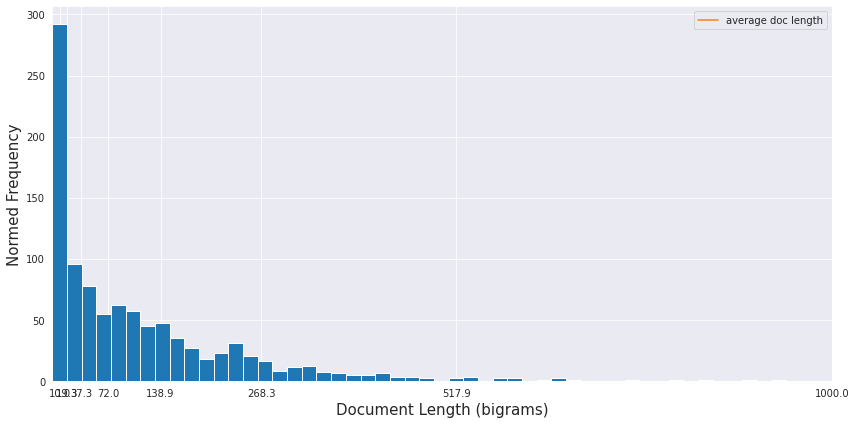

In [ ]:
# plot a histogram of document length
num_bins = 50
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (bigrams)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(10),stop=np.log10(1000),num=8, base=10.0))
plt.xlim(0,1000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('drive')
df2.to_csv('text_responses.csv')
!cp text_responses.csv "drive/My Drive/"

Mounted at drive


In [ ]:
# only keep articles with more than 25 tokens
df2 = df2[df2['Response Answer Bigrams'].map(len) >= 25]
# ensure all tokenized items are lists
df2 = df2[df2['Response Answer Bigrams'].map(type) == list]
df2.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df2), "accounts")

After cleaning and excluding short aticles, the dataframe now has: 673 accounts


In [ ]:
df2.head()

,Account Type,Account Number,Account Name,Response Answer,Tokenized Response Answer,Response Answer Bigrams
0,City,35853,City of Baltimore,Key findings by sector provide guidance for wh...,"[key, find, sector, provid, guidanc, strategi,...","[futur_emiss, ghg_emiss, emiss_energi, energi_..."
1,City,37241,City of Berkeley,Public facility. Industrial facilities. Reside...,"[public, facil, industri, facil, residenti, bu...","[public_facil, industri_facil, residenti_build..."
2,City,49787,City of Benicia,nan. nan. nan. Benicia's commitment to a healt...,"[benicia, commit, healthi, environ, resid, goe...","[activ_involv, environment_stewardship, health..."
3,City,52897,City of Aspen,As a part of the community-wide climate action...,"[part, communitywid, climat, action, plan, asp...","[climat_action, action_plan, set_target, targe..."
4,City,54092,City of Ann Arbor,This is an ambitious target for our city. Ther...,"[ambiti, target, citi, target, subnat, level, ...","[ambiti_target, level_target, unit_state, comm..."


## Build Topic Models

In [ ]:
def train_lda(data, num_topics, chunksize=None, alpha='symmetric', eta=None):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize

    * low alpha means each document is only represented by a small number of topics, and vice versa
    * low eta means each topic is only represented by a small number of words, and vice versa
    """
    dictionary = corpora.Dictionary(data['Response Answer Bigrams'])
    corpus = [dictionary.doc2bow(doc) for doc in data['Response Answer Bigrams']]
    t1 = time.time()
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=alpha, eta=eta, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(data), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [ ]:
#dictionary,corpus,lda = train_lda(train_df, 5, chunksize = 30, eta = 0.5e-2, alpha = 1e-2)
dictionary,corpus,lda = train_lda(df2, 20, chunksize=100)

Time to train LDA model on  673 articles:  0.024739352862040202 min


In [ ]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=20, num_words=10)

[(0,
  '0.038*"energi_effici" + 0.029*"effici_build" + 0.027*"build_servic" + 0.012*"real_estat" + 0.012*"emiss_reduct" + 0.008*"cost_save" + 0.007*"monetari_save" + 0.007*"payback_period" + 0.007*"pleas_specifi" + 0.006*"employe_commut"'),
 (1,
  '0.019*"lowcarbon_energi" + 0.017*"solar_pv" + 0.014*"energi_instal" + 0.012*"purchas_agreement" + 0.012*"custom_servic" + 0.012*"solar_panel" + 0.012*"renew_sourc" + 0.011*"renew_energi" + 0.010*"purchas_electr" + 0.009*"power_purchas"'),
 (2,
  '0.023*"emiss_reduct" + 0.014*"ghg_emiss" + 0.010*"energi_effici" + 0.007*"carbon_footprint" + 0.007*"process_emiss" + 0.007*"climat_chang" + 0.007*"north_america" + 0.007*"reduct_target" + 0.006*"greenhous_ga" + 0.005*"per_unit"'),
 (3,
  '0.016*"margin_abat" + 0.016*"develop_margin" + 0.016*"report_program" + 0.016*"ghg_intens" + 0.016*"instrument_air" + 0.015*"evalu_emiss" + 0.015*"use_intern" + 0.014*"ghg_emiss" + 0.014*"capit_power" + 0.013*"intens_product"'),
 (4,
  '0.019*"energi_effici" + 0.0

In [ ]:
def plot_topic_dist(idx):

  bow = dictionary.doc2bow(df2.iloc[idx,5])
  doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

  # bar plot of topic distribution for this document
  fig, ax = plt.subplots(figsize=(12,6));

  # the histogram of the data
  patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
  ax.set_xlabel('Topic ID', fontsize=15)
  ax.set_ylabel('Topic Contribution', fontsize=15)
  ax.set_title("Topic Distribution for: " + df2.iloc[idx, 2], fontsize=20)
  ax.set_xticks(np.linspace(0,20,5))
  fig.tight_layout()
  plt.show()

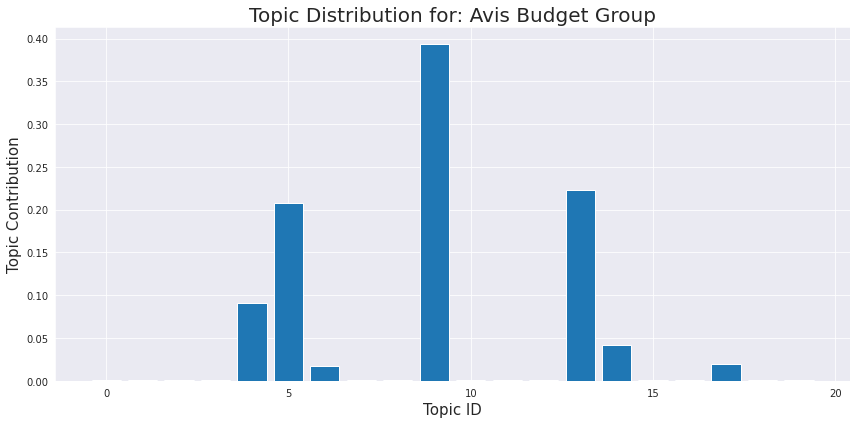

In [ ]:
rand_idx = np.random.randint(len(df2))
plot_topic_dist(rand_idx)

In [ ]:
# matrix of topic distributions for all 
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(673, 20)

## Compute Similarity Scores between Corporate & City Topic Distributions


In [ ]:
from scipy.spatial.distance import jensenshannon

def jensen_shannon(query, matrix):
  """ Finds Jensen-Shannon similarity between query account & every account in matrix """ 

  return np.array([jensenshannon(p,query) for p in matrix])

def get_most_similar_documents(query,matrix,k=10):
    """
    Implements the Jensen-Shannon distance
    and returns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return np.argsort(sims)[:k], np.sort(sims)[:k] # the top k positional index of the smallest Jensen Shannon distances

In [ ]:
idx = 0
new_bow = dictionary.doc2bow(df2.iloc[idx,5])
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

sims = jensen_shannon(new_doc_distribution, doc_topic_dist)
most_sim_ids, most_sims_score = get_most_similar_documents(new_doc_distribution, doc_topic_dist)

In [ ]:
most_similar_df = df2[df2.index.isin(most_sim_ids[0:3])]
most_similar_df['Account Name']
most_sims_score[4]

0.5243355747356068

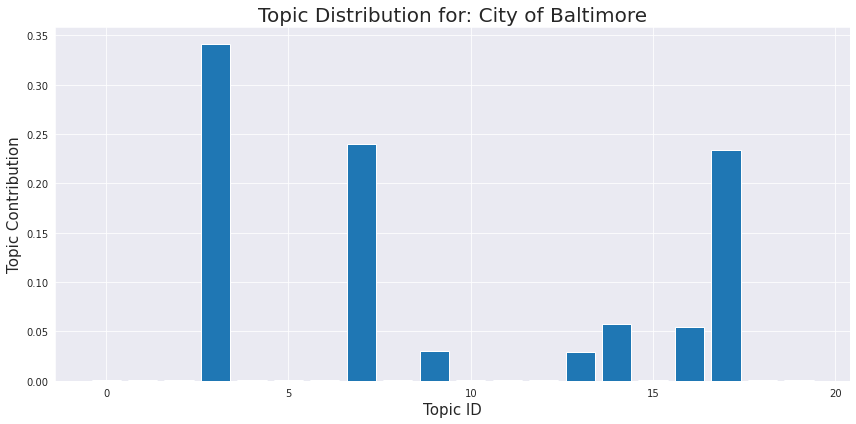

In [ ]:
plot_topic_dist(0)

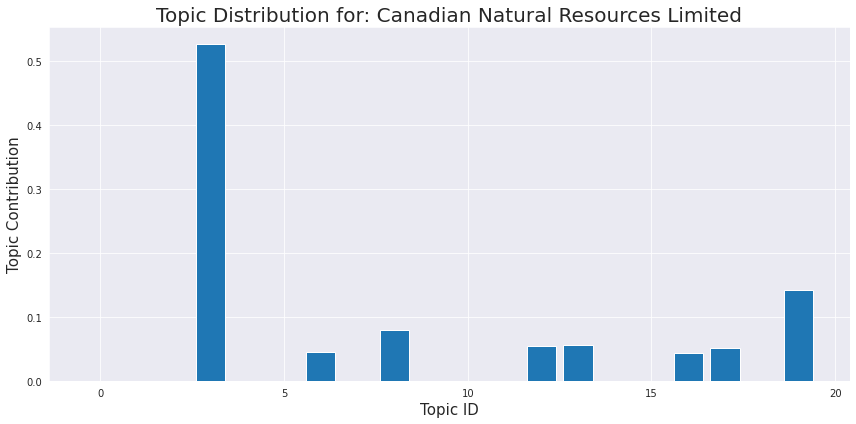

In [ ]:
plot_topic_dist(92)

## Build Free Text Similarity Matrix between Cities & Corporations

In [ ]:
city_idx = df2.index[df2['Account Type'] == 'City'].tolist()
corp_idx = df2.index[df2['Account Type'] == 'Corporation'].tolist()

sim_matrix = pd.DataFrame({'account_1' : [], 
                           'account_1_type': [],
                           'account_2':[], 
                           'account_2_type': [],
                           'sim_score': []})

for i in city_idx:
  b = dictionary.doc2bow(df2.iloc[i,5])
  d = np.array([tup[1] for tup in lda.get_document_topics(bow=b)])
  sim_scores = jensen_shannon(d, doc_topic_dist) # array for sim scores for city `i`

  append_df = pd.DataFrame({'account_1': df2.iloc[i,1],
                            'account_1_type': df2.iloc[i,0],
                            'account_2': df2['Account Number'],
                            'account_2_type': df2['Account Type'],
                            'sim_score': sim_scores})
  
  sim_matrix = sim_matrix.append(append_df, ignore_index=True)

sim_matrix = sim_matrix[sim_matrix['account_2_type'] == 'Corporation']
sim_matrix['account_1'] = sim_matrix['account_1'].astype('int')
sim_matrix['account_2'] = sim_matrix['account_2'].astype('int')
  
print(sim_matrix.shape)
print(len(city_idx) * len(corp_idx))

sim_matrix.head()


/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


(5320, 5)
5320


,account_1,account_1_type,account_2,account_2_type,sim_score
8,35853,City,58,Corporation,0.603660
9,35853,City,64,Corporation,0.730616
10,35853,City,119,Corporation,0.739552
11,35853,City,285,Corporation,0.685070
12,35853,City,291,Corporation,0.790877


In [ ]:
drive.mount('drive')
sim_matrix.to_csv('text_response_similarity_scores.csv')
!cp text_response_similarity_scores.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
